In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [2]:
df = pd.read_csv('data/df_grouped.csv')


In [3]:
df.columns

Index(['Indice di spopolamento', 'Indice di occupazione',
       'Indice disoccupazione',
       'Tipo di località_Altri comuni non altrimenti classificati',
       'Tipo di località_Capoluogo senza specifici interessi turistici',
       'Tipo di località_Città d'Arte', 'Tipo di località_Località collinari',
       'Tipo di località_Località lacuali', 'Tipo di località_Località marine',
       'Tipo di località_Località montane',
       'Tipo di località_Località religiose',
       'Tipo di località_Località termali', 'PC_Economica', 'PC_Metropoli',
       'PC_Diversificata', 'PC_Qualita_Alta', 'PC_Business', 'PC_Balneare',
       'PC_Montano', 'PC_Costiero_Minore', 'PC_Balneare_Massa',
       'PC_Religioso_Culturale', 'PC_Lusso_Termale', 'PC_Enogastronomico',
       'PC_Lacustre_Transito', 'Macroarea_Isole', 'Macroarea_Nord',
       'Macroarea_Sud',
       'Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico',
       'Descrizione_Tipologia_di_Immobile_Abitazioni_signorili',

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 33 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   Indice di spopolamento                                           8181 non-null   float64
 1   Indice di occupazione                                            8181 non-null   float64
 2   Indice disoccupazione                                            8179 non-null   float64
 3   Tipo di località_Altri comuni non altrimenti classificati        8182 non-null   bool   
 4   Tipo di località_Capoluogo senza specifici interessi turistici   8182 non-null   bool   
 5   Tipo di località_Città d'Arte                                    8182 non-null   bool   
 6   Tipo di località_Località collinari                              8182 non-null   bool   
 7   Tipo di località_Località lacuali         

In [5]:
# Define the preprocessing steps
x_vars = ["Indice di spopolamento",
          "Indice di occupazione",
          "Indice disoccupazione",
          "Tipo di località_Altri comuni non altrimenti classificati",
          "Tipo di località_Capoluogo senza specifici interessi turistici",
          "Tipo di località_Città d\'Arte","Tipo di località_Località collinari",
          "Tipo di località_Località lacuali","Tipo di località_Località marine",
          "Tipo di località_Località montane","Tipo di località_Località religiose",
          "Tipo di località_Località termali", 
          "PC_Economica",
          "PC_Metropoli",
          "PC_Diversificata",
          "PC_Qualita_Alta",
          "PC_Business",
          "PC_Balneare",
          "PC_Montano",
          "PC_Costiero_Minore",
          "PC_Balneare_Massa",
          "PC_Religioso_Culturale",
          "PC_Lusso_Termale",
          "PC_Enogastronomico", 
          "PC_Lacustre_Transito", 
          "Macroarea_Isole", "Macroarea_Nord", "Macroarea_Sud",
          "Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_signorili", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_tipiche_dei_luoghi",
          "Descrizione_Tipologia_di_Immobile_Ville_e_Villini"]

X = df[x_vars]
y = df["Media Costo alla Vendita"]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
# Prima di fare la normalizzazione, rimuovi la riga con NaN
mask = ~X_train.isnull().any(axis=1)
X_train_clean = X_train[mask]
y_train_clean = y_train[mask]

print(f"Righe rimosse: {len(X_train) - len(X_train_clean)}")
print(f"Nuove dimensioni: X_train {X_train_clean.shape}, y_train {y_train_clean.shape}")

Righe rimosse: 1
Nuove dimensioni: X_train (6544, 32), y_train (6544,)


In [8]:
print("Range y_train:", y_train.min(), "to", y_train.max())
print("Range y_test:", y_test.min(), "to", y_test.max())
print("Range X_train:", X_train.min().min(), "to", X_train.max().max())

Range y_train: 0.0 to 13450.0
Range y_test: 0.0 to 11600.0
Range X_train: -252.0 to 70.3


In [9]:
# Normalizza X (features)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_clean)
X_test_scaled = scaler_X.transform(X_test)

# Normalizza y (target)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Verifica che ora sia tutto OK
print("X_train_scaled range:", X_train_scaled.min(), "to", X_train_scaled.max())
print("y_train_scaled range:", y_train_scaled.min(), "to", y_train_scaled.max())

X_train_scaled range: -18.815057972840137 to 80.88881257627656
y_train_scaled range: -1.4939893422192638 to 17.757595232106112


In [10]:
print("NaN in X_train:", X_train.isnull().sum().sum())
print("NaN in y_train:", y_train.isnull().sum())
print("Inf in X_train:", np.isinf(X_train).sum().sum())

NaN in X_train: 1
NaN in y_train: 0
Inf in X_train: 0


In [11]:
# Verifica che ora siano normalizzati
print("X_train_scaled range:", X_train_scaled.min(), "to", X_train_scaled.max())
print("y_train_scaled range:", y_train_scaled.min(), "to", y_train_scaled.max())

X_train_scaled range: -18.815057972840137 to 80.88881257627656
y_train_scaled range: -1.4939893422192638 to 17.757595232106112


In [12]:
# Vedi le statistiche delle colonne di X_train_clean
print(X_train_clean.describe())

# Trova eventuali valori estremi solo per colonne numeriche (escludi bool)
print("\nValori molto alti/bassi per colonna:")
for col in X_train_clean.columns:
    if pd.api.types.is_numeric_dtype(X_train_clean[col]) and X_train_clean[col].dtype != bool:
        q99 = X_train_clean[col].quantile(0.99)
        q01 = X_train_clean[col].quantile(0.01)
        max_val = X_train_clean[col].max()
        min_val = X_train_clean[col].min()
        if max_val > q99 * 3 or min_val < q01 * 3:
            print(f"{col}: min={min_val}, max={max_val}, Q1%={q01}, Q99%={q99}")

       Indice di spopolamento  Indice di occupazione  Indice disoccupazione  \
count             6544.000000            6544.000000            6544.000000   
mean                -1.642772              44.962913              12.490338   
std                 13.307233               7.493671               6.440995   
min               -252.000000              21.700000               0.970000   
25%                 -7.100000              38.975000               7.560000   
50%                 -0.900000              45.700000              10.385000   
75%                  4.700000              50.725000              16.770000   
max                 69.800000              70.300000              39.420000   

       PC_Economica  PC_Metropoli  PC_Diversificata  PC_Qualita_Alta  \
count   6544.000000   6544.000000       6544.000000      6544.000000   
mean      -0.622764     -1.070643          0.214200        -0.287118   
std        0.896156      1.892311          1.229494         1.243282   


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Per X - MinMaxScaler (più robusto agli outliers)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_clean)
X_test_scaled = scaler_X.transform(X_test)

# Per y - tieni StandardScaler (va bene)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clean.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print("X_train_scaled range:", X_train_scaled.min(), "to", X_train_scaled.max())

X_train_scaled range: 0.0 to 1.0


In [14]:

print("X_train_scaled range:", X_train_scaled.min(), "to", X_train_scaled.max())
print("y_train_scaled range:", y_train_scaled.min(), "to", y_train_scaled.max())

X_train_scaled range: 0.0 to 1.0
y_train_scaled range: -1.4939893422192638 to 17.757595232106112


# Hyperparameters optimization

In [18]:
# Funzione per definire il modello con iperparametri variabili
def build_model(hp):
    model = Sequential()
    # Primo livello
    model.add(Dense(units=hp.Fixed("units_1", 256),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    # Secondo livello
    model.add(Dense(units=hp.Int("units_2", min_value=128, max_value=256, step=32),
                    activation="relu"))
    # Terzo livello opzionale
    if hp.Boolean("add_third_layer"):
        model.add(Dense(units=hp.Int("units_3", min_value=32, max_value=256, step=32),
                        activation="relu"))
    # Livello di output
    model.add(Dense(1))  # Nessuna attivazione per regressione
    # Compilazione del modello
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [24]:
# Creazione del tuner per cercare i migliori iperparametri
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_tuner',
    project_name='house_price_prediction'
)

# Callback per interrompere l'addestramento se non ci sono miglioramenti
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Ricerca degli iperparametri migliori
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])


Trial 254 Complete [00h 01m 15s]
val_loss: 1117612.125

Best val_loss So Far: 410404.90625
Total elapsed time: 00h 52m 56s


In [25]:
# Mostrare i migliori iperparametri trovati
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Migliori iperparametri trovati:")
print(f"- Unità nel primo livello: {best_hps.get("units_1")}")
print(f"- Unità nel secondo livello: {best_hps.get("units_2")}")
if best_hps.get("add_third_layer"):
    print(f"- Unità nel terzo livello: {best_hps.get("units_3")}")
print(f"- Learning rate: {best_hps.get("learning_rate")}")



Migliori iperparametri trovati:
- Unità nel primo livello: 256
- Unità nel secondo livello: 224
- Learning rate: 0.01


In [26]:
# Costruzione del modello con i migliori iperparametri
best_model = tuner.hypermodel.build(best_hps)
# Addestramento del modello con i migliori iperparametri
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])


c:\Users\Acer\OneDrive\Desktop\DevlHope\Team4 - Immobili\repo\real_estate_predictive_model\lucia.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 644153.0000 - mae: 514.6702 - val_loss: 1405667.1250 - val_mae: 997.7584
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1509924.8750 - mae: 994.9419 - val_loss: 981851.2500 - val_mae: 757.6348
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1072096.5000 - mae: 684.1569 - val_loss: 454191.3750 - val_mae: 416.6167
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 553371.6875 - mae: 439.4633 - val_loss: 410504.4062 - val_mae: 428.9053
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 488192.7188 - mae: 449.4060 - val_loss: 410794.4375 - val_mae: 431.5202
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 464398.2188 - mae: 448.9545 - val_loss: 411298.5312 - val_mae: 434.3785
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 466028.3438 - mae: 448.3636 - val_loss: 411206.4062 - val_mae: 433.9220
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 463823.0000 

In [27]:
y_pred = best_model.predict(X_test)
# Calcolo delle metriche
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error (MAE): 486.1106692237681
Mean Squared Error (MSE): 635934.3615515004
Root Mean Squared Error (RMSE): 797.454927598733
R-squared (R2): -0.0010700285686002786


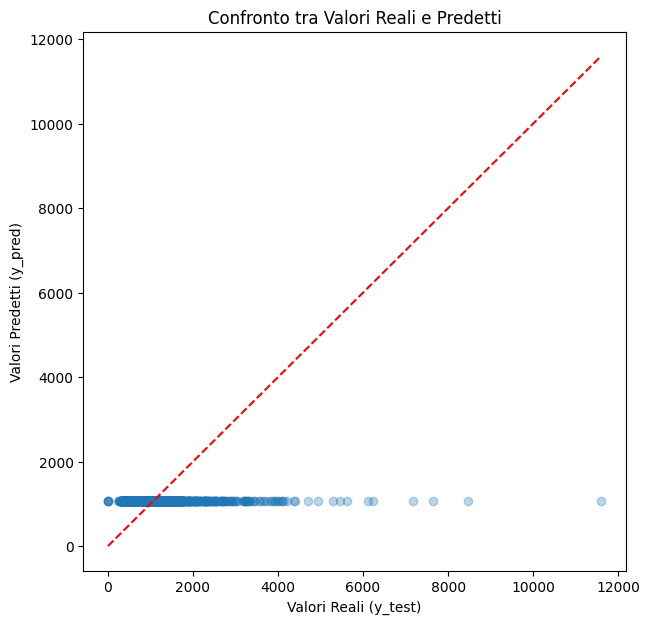

In [28]:
# Grafico di confronto tra valori reali e predetti
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valori Reali (y_test)")
plt.ylabel("Valori Predetti (y_pred)")
plt.title("Confronto tra Valori Reali e Predetti")
plt.show()